In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pm4py

C:\Users\yeska\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
%xmode Minimal

Exception reporting mode: Minimal


## Предобработка

In [3]:
df = pd.read_csv(r'C:\hackathon_sber_pm_2023\Доставка_продуктов.csv', sep=';', encoding='windows-1251')
df.head()

,case,stage,start_time,end_time
0,77654086061,Заказ оформлен,05.10.2022 17:57,05.10.2022 17:57
1,77654086061,Поступление заказа сборщику,05.10.2022 17:57,05.10.2022 17:58
2,77654086061,Сборка заказа,05.10.2022 17:58,05.10.2022 18:22
3,77654086061,Упаковка товара,05.10.2022 18:22,05.10.2022 18:24
4,77654086061,Оплата,05.10.2022 18:24,05.10.2022 18:24


In [4]:
#Число уникальных кейсов
df['case'].nunique()

19988

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179030 entries, 0 to 179029
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   case        179030 non-null  int64 
 1   stage       179030 non-null  object
 2   start_time  179030 non-null  object
 3   end_time    179030 non-null  object
dtypes: int64(1), object(3)
memory usage: 5.5+ MB


In [6]:
#перевел время в нормальный формат
df['start_time'] = pd.to_datetime(df.start_time, format='%d.%m.%Y %H:%M')
df['end_time'] = pd.to_datetime(df.end_time, format='%d.%m.%Y %H:%M')

In [7]:
#время каждой операции в минутах
df['op_time_minutes'] = (df.end_time.astype('int64') - df.start_time.astype('int64')) // 10**9 / 60

#день начала и конца каждой операции
df['start_time_day'] = df.start_time.dt.date
df['end_time_day'] = df.start_time.dt.date

In [8]:
df.head(3)

,case,stage,start_time,end_time,op_time_minutes,start_time_day,end_time_day
0,77654086061,Заказ оформлен,2022-10-05 17:57:00,2022-10-05 17:57:00,0.0,2022-10-05,2022-10-05
1,77654086061,Поступление заказа сборщику,2022-10-05 17:57:00,2022-10-05 17:58:00,1.0,2022-10-05,2022-10-05
2,77654086061,Сборка заказа,2022-10-05 17:58:00,2022-10-05 18:22:00,24.0,2022-10-05,2022-10-05


In [9]:
stage_pivot = df.pivot_table(index = 'case',
              columns='stage',
              values = 'op_time_minutes',
              aggfunc='count').fillna(0)

In [10]:
stage_pivot.head()

stage,Доставка заказа,Заказ доставлен,Заказ оформлен,Звонок клиенту,Оплата,Отмена заказа,Передача товара курьеру,Поступление заказа сборщику,Проверка заказа,Сборка заказа,Упаковка товара
case,,,,,,,,,,,
10007845189,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
10013763250,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
10017161163,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
10024115929,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,2.0
10027814634,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


## Исследование отменённых и неотмененных заказов

In [11]:
#процент отмен заказов:
df.loc[df.stage=='Отмена заказа'].case.nunique()/df.case.nunique()*100

24.57974784870923

In [12]:
#Сводная таблица суммы времени выполенения каждой стадии для каждого кейса
stage_sum_pivot = df.pivot_table(index = 'case',
              columns='stage',
              values = 'op_time_minutes',
              aggfunc="sum").fillna(0)
stage_sum_pivot.shape

(19988, 11)

In [13]:
stage_sum_pivot.head()

stage,Доставка заказа,Заказ доставлен,Заказ оформлен,Звонок клиенту,Оплата,Отмена заказа,Передача товара курьеру,Поступление заказа сборщику,Проверка заказа,Сборка заказа,Упаковка товара
case,,,,,,,,,,,
10007845189,33.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,2.0,24.0,2.0
10013763250,33.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,2.0,24.0,2.0
10017161163,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,24.0,2.0
10024115929,32.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,2.0,24.0,4.0
10027814634,33.0,0.0,0.0,0.0,1.0,0.0,5.0,1.0,1.0,24.0,1.0


In [14]:
#средний и медианный хронометраж заказа в минутах
stage_sum_pivot.describe().loc[['mean', '50%']].round(1)

stage,Доставка заказа,Заказ доставлен,Заказ оформлен,Звонок клиенту,Оплата,Отмена заказа,Передача товара курьеру,Поступление заказа сборщику,Проверка заказа,Сборка заказа,Упаковка товара
mean,29.1,0.1,0.1,0.4,0.4,0.0,6.0,2.3,1.3,27.1,2.0
50%,32.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,2.0,24.0,2.0


In [15]:
any_mean_time, any_median_time = (round(stage_sum_pivot.mean().sum(), 1), round(stage_sum_pivot.median().sum(), 1))
#среднее и медианное время любого заказа
any_mean_time, any_median_time

(68.8, 65.0)

In [16]:
#хронометрах среднего и медианного отмененого заказ в минутах
stage_sum_pivot[stage_sum_pivot["Отмена заказа"] == 1].describe().loc[['mean', '50%']].round(1)

stage,Доставка заказа,Заказ доставлен,Заказ оформлен,Звонок клиенту,Оплата,Отмена заказа,Передача товара курьеру,Поступление заказа сборщику,Проверка заказа,Сборка заказа,Упаковка товара
mean,17.5,0.0,0.1,0.7,0.2,1.0,3.4,2.4,0.1,26.3,1.6
50%,31.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,0.0,24.0,2.0


In [17]:
cancelled_mean_time, cancelled_median_time = (round(stage_sum_pivot[stage_sum_pivot["Отмена заказа"]==1].mean().sum(), 1), \
                                              round(stage_sum_pivot[stage_sum_pivot["Отмена заказа"]==1].median().sum(), 1))
#среднее  и медианное время отмененного заказа
cancelled_mean_time, cancelled_median_time

(53.3, 62.0)

In [18]:
#хронометрах среднего и медианного оттмененого заказ в минутах
stage_sum_pivot[stage_sum_pivot["Отмена заказа"] == 0].describe().loc[['mean', '50%']].round(1)

stage,Доставка заказа,Заказ доставлен,Заказ оформлен,Звонок клиенту,Оплата,Отмена заказа,Передача товара курьеру,Поступление заказа сборщику,Проверка заказа,Сборка заказа,Упаковка товара
mean,29.4,0.1,0.1,0.4,0.4,0.0,6.0,2.3,1.3,27.1,2.0
50%,33.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,2.0,24.0,2.0


In [19]:
approved_mean_time, cancelled_mean_time = (round(stage_sum_pivot[stage_sum_pivot["Отмена заказа"]==0].mean().sum(), 1), \
                                           round(stage_sum_pivot[stage_sum_pivot["Отмена заказа"]==0].median().sum(), 1))
#среднее и медаинное время НЕотмененного заказа
approved_mean_time, cancelled_mean_time

(69.1, 66.0)

In [20]:
cancelled_cases = list(stage_pivot[stage_pivot["Отмена заказа"] == 1].index)

In [21]:
df.query("case in @cancelled_cases").head()

,case,stage,start_time,end_time,op_time_minutes,start_time_day,end_time_day
0,77654086061,Заказ оформлен,2022-10-05 17:57:00,2022-10-05 17:57:00,0.0,2022-10-05,2022-10-05
1,77654086061,Поступление заказа сборщику,2022-10-05 17:57:00,2022-10-05 17:58:00,1.0,2022-10-05,2022-10-05
2,77654086061,Сборка заказа,2022-10-05 17:58:00,2022-10-05 18:22:00,24.0,2022-10-05,2022-10-05
3,77654086061,Упаковка товара,2022-10-05 18:22:00,2022-10-05 18:24:00,2.0,2022-10-05,2022-10-05
4,77654086061,Оплата,2022-10-05 18:24:00,2022-10-05 18:24:00,0.0,2022-10-05,2022-10-05


In [22]:
#посчитаем число заказов разных типов в день
count_all_by_day = df.groupby(df.start_time_day)['case'].nunique()
count_cancelled_by_day = df.loc[df.stage=='Отмена заказа'].groupby(df.start_time_day)['case'].nunique()
count_approved_by_day = count_all_by_day - count_cancelled_by_day

In [23]:
counts_df = pd.DataFrame({'all': count_all_by_day, "cancelled": count_cancelled_by_day, 'approved':count_approved_by_day})

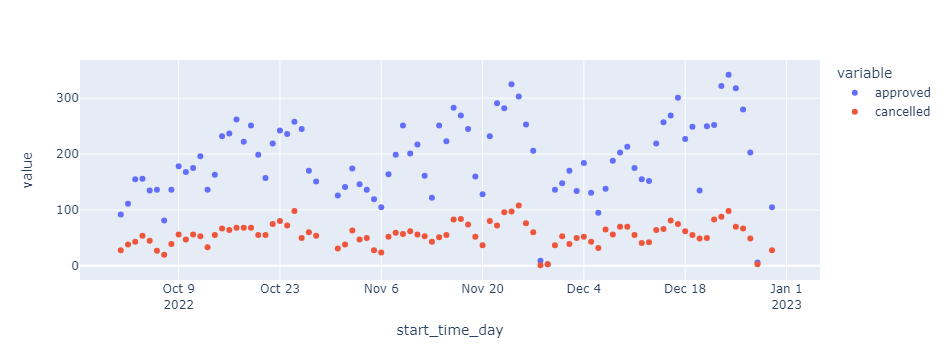

In [25]:
#график числа заказов в день
px.scatter(
        counts_df.loc[:, ['approved', 'cancelled']])

C:\Users\yeska\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\yeska\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

C:\Users\yeska\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

C:\Users\yeska\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silen

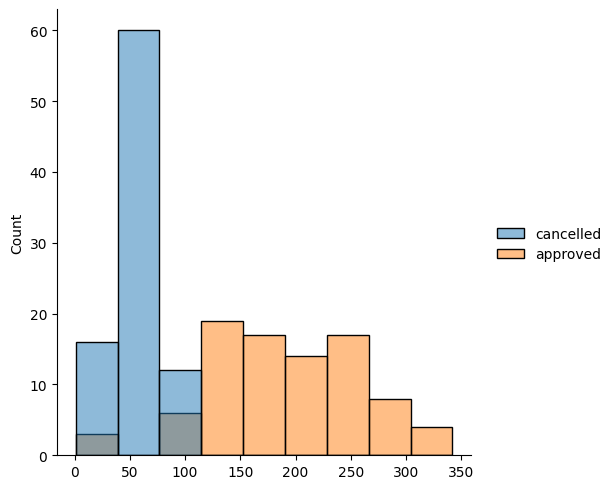

In [26]:
sns.displot(counts_df.loc[:, ['cancelled', 'approved']])

каждый конец месяца сильный провал по числу заказов


In [28]:
# посмотроим конкретный заказ
df[df.start_time.astype(str).str.contains('2022-12-28')].groupby('case').agg('first')

,stage,start_time,end_time,op_time_minutes,start_time_day,end_time_day
case,,,,,,
10484820203,Доставка заказа,2022-12-28 00:02:00,2022-12-28 00:35:00,33.0,2022-12-28,2022-12-28
14246939781,Проверка заказа,2022-12-28 00:15:00,2022-12-28 00:16:00,1.0,2022-12-28,2022-12-28
24497791992,Упаковка товара,2022-12-28 00:06:00,2022-12-28 00:08:00,2.0,2022-12-28,2022-12-28
30282567892,Оплата,2022-12-28 00:00:00,2022-12-28 00:01:00,1.0,2022-12-28,2022-12-28
49322145950,Упаковка товара,2022-12-28 00:07:00,2022-12-28 00:09:00,2.0,2022-12-28,2022-12-28
56133235112,Проверка заказа,2022-12-28 00:01:00,2022-12-28 00:02:00,1.0,2022-12-28,2022-12-28
62224667727,Доставка заказа,2022-12-28 00:00:00,2022-12-28 00:32:00,32.0,2022-12-28,2022-12-28
82528764762,Упаковка товара,2022-12-28 00:00:00,2022-12-28 00:03:00,3.0,2022-12-28,2022-12-28
86276783755,Проверка заказа,2022-12-28 00:22:00,2022-12-28 00:24:00,2.0,2022-12-28,2022-12-28


In [30]:
df[df.start_time.astype(str).str.contains('2022-10-31')].query('stage=="Заказ оформлен"')

,case,stage,start_time,end_time,op_time_minutes,start_time_day,end_time_day
877,71314275445,Заказ оформлен,2022-10-31 14:22:00,2022-10-31 14:22:00,0.0,2022-10-31,2022-10-31
968,65386994596,Заказ оформлен,2022-10-31 16:38:00,2022-10-31 16:38:00,0.0,2022-10-31,2022-10-31
1865,26461136432,Заказ оформлен,2022-10-31 21:23:00,2022-10-31 21:23:00,0.0,2022-10-31,2022-10-31
2863,55362595594,Заказ оформлен,2022-10-31 08:21:00,2022-10-31 08:21:00,0.0,2022-10-31,2022-10-31
4113,13932075963,Заказ оформлен,2022-10-31 08:12:00,2022-10-31 08:12:00,0.0,2022-10-31,2022-10-31
...,...,...,...,...,...,...,...
178326,79208839647,Заказ оформлен,2022-10-31 21:35:00,2022-10-31 21:36:00,1.0,2022-10-31,2022-10-31
178482,68711713327,Заказ оформлен,2022-10-31 20:40:00,2022-10-31 20:40:00,0.0,2022-10-31,2022-10-31
178580,88454548816,Заказ оформлен,2022-10-31 15:04:00,2022-10-31 15:04:00,0.0,2022-10-31,2022-10-31
178588,72020936275,Заказ оформлен,2022-10-31 08:21:00,2022-10-31 08:21:00,0.0,2022-10-31,2022-10-31


In [30]:
# время выполенения по заказу в минутах
op_time_by_case = df.groupby("case").agg({"op_time_minutes":"sum", "start_time_day": "first"})
op_time_by_case.sort_values('op_time_minutes')

,op_time_minutes,start_time_day
case,,
12574564931,0.0,2022-10-05
59782342610,0.0,2022-11-21
72486017297,0.0,2022-12-07
41495227466,0.0,2022-11-02
64591323859,0.0,2022-10-11
...,...,...
20055975786,159.0,2022-12-21
16435919915,159.0,2022-12-23
69136924716,159.0,2022-10-26


In [32]:
df[df.case==12574564931]

,case,stage,start_time,end_time,op_time_minutes,start_time_day,end_time_day
178404,12574564931,Заказ оформлен,2022-10-05 16:17:00,2022-10-05 16:17:00,0.0,2022-10-05,2022-10-05
178405,12574564931,Отмена заказа,2022-10-05 16:17:00,2022-10-05 16:17:00,0.0,2022-10-05,2022-10-05


In [33]:
# среднее время заказа в день
mean_op_time_by_day = op_time_by_case.\
                groupby('start_time_day').agg({"op_time_minutes":"min"})

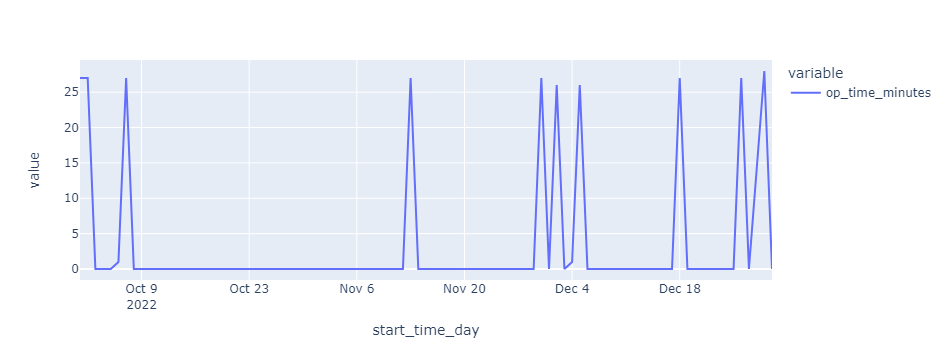

In [34]:
# график среднего времени заказа в день
px.line(mean_op_time_by_day)

### Исследуем с помощью pm4py

In [41]:
dataframe = df.copy()

In [42]:
event_log = pm4py.format_dataframe(dataframe, case_id='case', activity_key='stage', timestamp_key='start_time')
#event_log = pm4py.convert_to_event_log(event_log)

In [43]:
start_activities = pm4py.get_start_activities(event_log)
end_activities = pm4py.get_end_activities(event_log)
end_activities

{'Заказ доставлен': 15100, 'Отмена заказа': 4888}

In [44]:
start_activities

{'Заказ оформлен': 19988}

In [39]:
end_activities

{'Заказ доставлен': 15100, 'Отмена заказа': 4888}

DFG-диаграмма ('Directly Followed Graph')

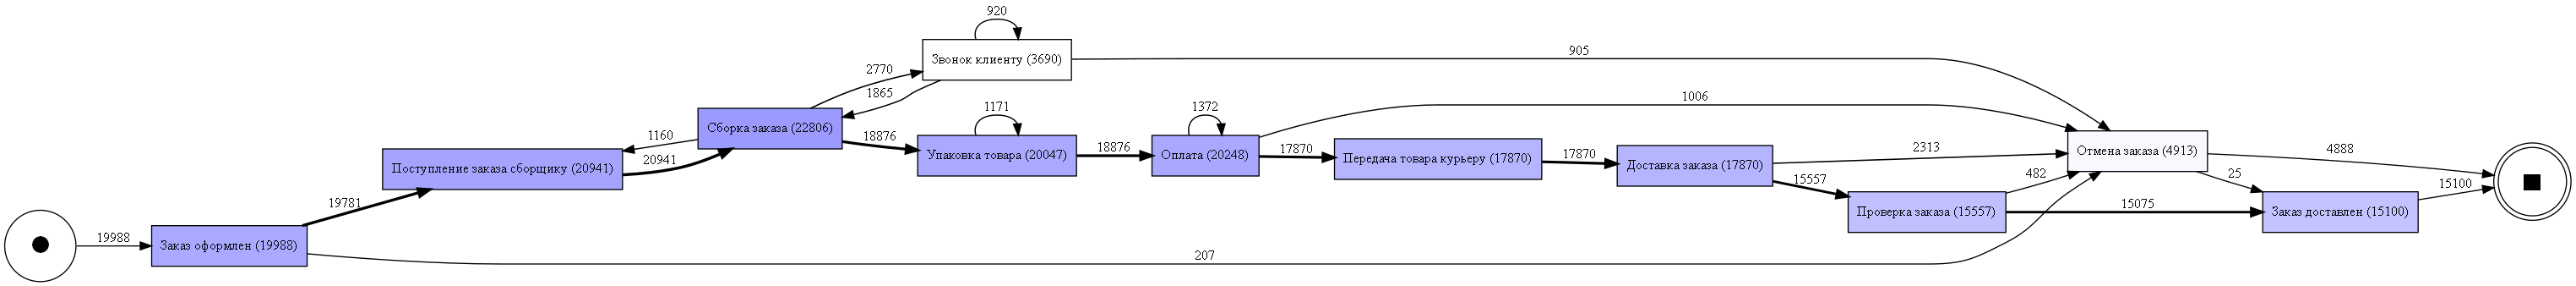

In [42]:
dfg, start_activities, end_activities = pm4py.discover_dfg(event_log)
pm4py.view_dfg(dfg, start_activities, end_activities)

In [49]:
# map = pm4py.discover_heuristics_net(event_log)
# pm4py.view_heuristics_net(map)

In [50]:
df1 = df.query("case in @cancelled_cases")

In [51]:
cancelled_log = pm4py.format_dataframe(df1 , case_id='case', activity_key='stage', timestamp_key='start_time')
#event_log = pm4py.convert_to_event_log(event_log)

C:\Users\yeska\AppData\Roaming\Python\Python311\site-packages\pm4py\utils.py:77: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\yeska\AppData\Roaming\Python\Python311\site-packages\pm4py\utils.py:81: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\yeska\AppData\Roaming\Python\Python311\site-packages\pm4py\utils.py:85: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

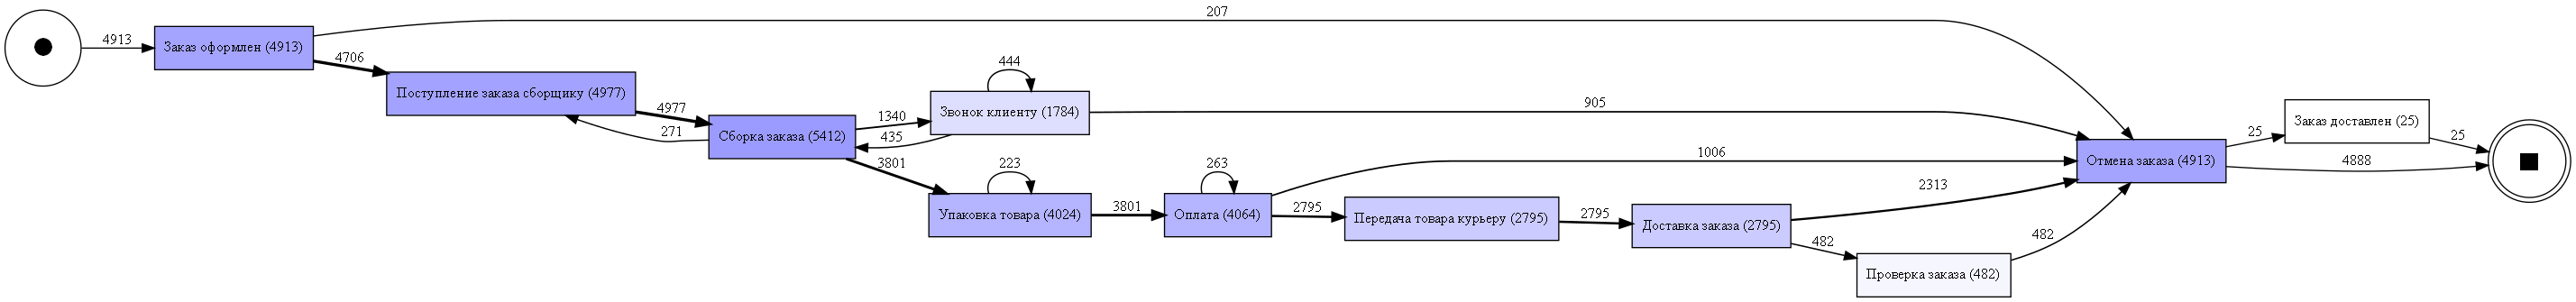

In [53]:
# DFG-диаграмма только отмененных заказов
dfg, start_activities, end_activities = pm4py.discover_dfg(cancelled_log)
pm4py.view_dfg(dfg, start_activities, end_activities)

In [54]:
# сразу выше заметна ошибка - после отмены заказа 25 раз идет доставка заказа

In [58]:
# посмотрим распределение времени заказа
cases_time = df.groupby("case").agg({"start_time":"first", "end_time":'last'})
cases_time['case_time'] = (cases_time.end_time.astype('int64') - cases_time.start_time.astype('int64'))// 10**9 / 60

In [59]:
cases_time['start_time_day'] = cases_time.start_time.dt.date
cases_time_max = cases_time.groupby("start_time_day").agg({"case_time":'max'})

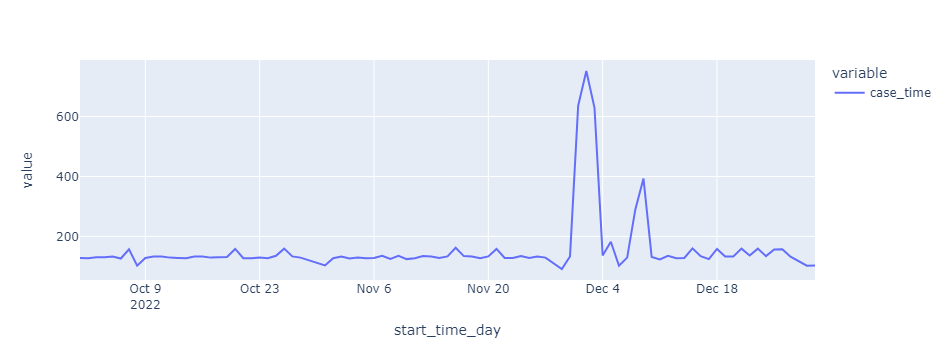

In [60]:
px.line(cases_time_max)

сильная аномалия в первые три дня декабря.

In [66]:
# максимальый хронометраж заказа в день
max_time_by_day = df[df.stage=="Поступление заказа сборщику"].groupby("start_time_day").\
        agg({"op_time_minutes":max}).sort_values("op_time_minutes", ascending=True)
max_time_by_day

C:\Users\yeska\AppData\Local\Temp\ipykernel_18792\4279397189.py:3: FutureWarning:

The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.



,op_time_minutes
start_time_day,
2022-11-29,1.0
2022-12-29,2.0
2022-11-05,33.0
2022-12-04,33.0
2022-10-06,33.0
...,...
2022-11-02,34.0
2022-11-08,35.0
2022-12-12,35.0
